# Advanced Lane Line Detection Using OpenCV
### Galen Ballew, March 2017
---

This notebook provides a robust solution to lane line detection and tracking for self driving cars. The steps are as listed:

1. Camera Calibration  
2. Distortion Correction   
3. Gradient and Color Thresholding   
4. Perspective Transform   
5. Lane Line Search & Search Optimization
6. Drawing the lane overlay

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import io
import os
import glob
%matplotlib inline

Let's take a look at a sample calibration image.

In [2]:
images = glob.glob('camera_cal/calibration*.jpg')

Note: Make sure you use the correct grayscale conversion depending on how you've read in your images. Use cv2.COLOR_RGB2GRAY if you've read in an image using mpimg.imread(). Use cv2.COLOR_BGR2GRAY if you've read in an image using cv2.imread().

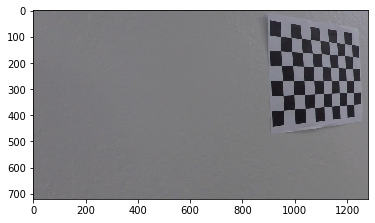

In [3]:
img = mpimg.imread(images[0])
plt.imshow(img);

### Camera Calibration

We need to store the number of *object points*, or locations of interest on the chessboard. Only points that are not on the outermost edge are considered. For this board, there are 9 columns on the X-axis and 6 rows on the 7 axis. We will want a list of (x, y, z) coordinates for each combination (i.e. unique location on the board). Every z-value will be zero since it is a 2D image.

In [4]:
# store chessboard coordinates
chess_points = []
# store points from transformed img
image_points = []

In [5]:
# board is 6 rows by 9 columns. each item is one (xyz) point 
# remember, only care about inside points. that is why board is 9x6, not 10x7
chess_point = np.zeros((9*6, 3), np.float32)
# z stays zero. set xy to grid values
chess_point[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

In [6]:
for image in images:
    
    img = mpimg.imread(image)
    # convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    
    # returns boolean and coordinates
    success, corners = cv.findChessboardCorners(gray, (9,6), None)
    
    if success:
        image_points.append(corners)
        #these will all be the same since it's the same board
        chess_points.append(chess_point)
    else:
        print('corners not found {}'.format(image))
        

corners not found camera_cal/calibration1.jpg
corners not found camera_cal/calibration4.jpg
corners not found camera_cal/calibration5.jpg


<Figure size 432x288 with 0 Axes>

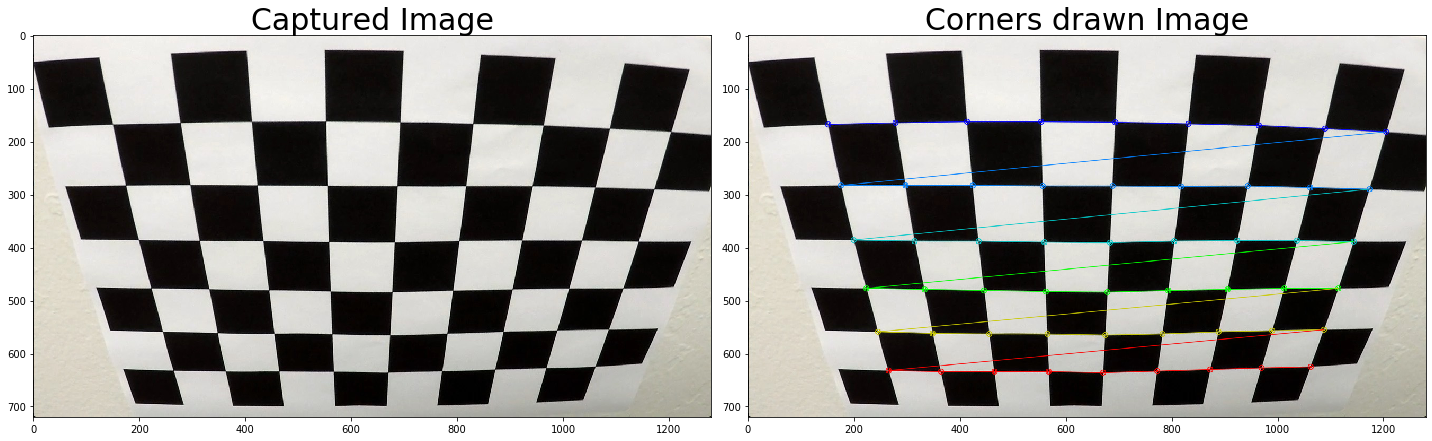

In [7]:
image = mpimg.imread('./camera_cal/calibration2.jpg')

plt.figure();
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(image);
ax1.set_title('Captured Image', fontsize=30);

gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY) 
ret , corners = cv.findChessboardCorners(gray,(9,6),None)    
if ret == False:
    print('corners not found')
img1 = cv.drawChessboardCorners(image,(9,6),corners,ret) 

ax2.imshow(img1);
ax2.set_title('Corners drawn Image', fontsize=30);
plt.tight_layout();
plt.savefig('saved_figures/chess_corners.png');
plt.show;

In [8]:
# Save everything!
# points_pkl = {}
# points_pkl["chesspoints"] = chess_points
# points_pkl["imagepoints"] = image_points
# points_pkl["imagesize"] = (img.shape[1], img.shape[0])
# pickle.dump(points_pkl,open("object_and_image_points.pkl", "wb" ))

Huzzah! OpenCV successfully mapped the corners. The next step will be to use this mapping to correct for the  distortion that occurs at the edges of a camera lens.

---

### Distortion Correction

In [9]:
points_pickle = pickle.load( open( "object_and_image_points.pkl", "rb" ) )
chess_points = points_pickle["chesspoints"]
image_points = points_pickle["imagepoints"]
img_size = points_pickle["imagesize"]

In [10]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(chess_points, image_points, img_size, None, None)

In [11]:
# camera = {}
# camera["mtx"] = mtx
# camera["dist"] = dist
# camera["imagesize"] = img_size
# pickle.dump(camera, open("camera_matrix.pkl", "wb"))

In [12]:
def distort_correct(img,mtx,dist,camera_img_size):
    img_size1 = (img.shape[1],img.shape[0])
    #print(img_size1)
    #print(camera_img_size)
    assert (img_size1 == camera_img_size),'image size is not compatible'
    undist = cv.undistort(img, mtx, dist, None, mtx)
    return undist

<Figure size 432x288 with 0 Axes>

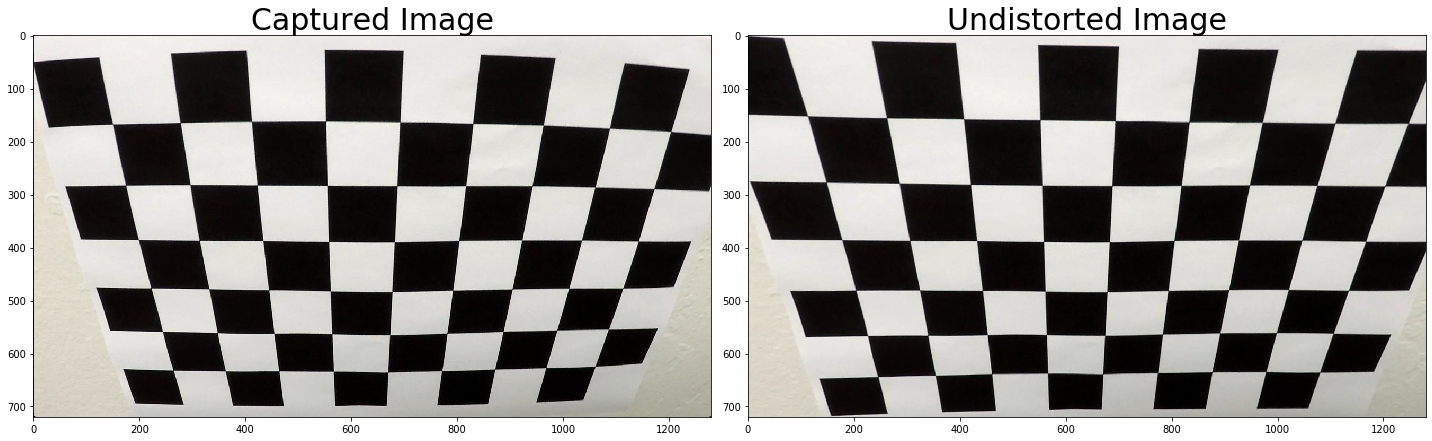

In [13]:
img = mpimg.imread('./camera_cal/calibration2.jpg')
img_size1 = (img.shape[1], img.shape[0])

undist = distort_correct(img, mtx, dist, img_size)

### Visualize the captured 
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(img);
ax1.set_title('Captured Image', fontsize=30);
ax2.imshow(undist);
ax2.set_title('Undistorted Image', fontsize=30);
plt.tight_layout()
plt.savefig('saved_figures/undistorted_chess.png')

It's subtle, but the size of the chess squares are accurate even at the edge of the image. 

---

### Gradient & Color Thresholding

For this project we will be using several filters to generate a binary (black & white) image that we can detect and track the lane lines with. 

* Sobel gradients in the x & y directions
* Gradient magnitude
* Gradient direction
* Color space transform and filtering

In [18]:
# load camera matrix and distortion matrix
camera = pickle.load(open( "camera_matrix.pkl", "rb" ))
mtx = camera['mtx']
dist = camera['dist']
camera_img_size = camera['imagesize']

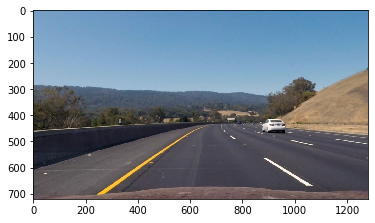

In [19]:
# get an undistorted dashcam frame
import cv2
image = mpimg.imread('test_images/test3.jpg')
dim = (1280, 720)
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
image = distort_correct(image,mtx,dist,camera_img_size)
plt.imshow(image);

#### Sobel gradients
Canny Edge Detection combines the sobel gradient for both x and y. By breaking it apart into its components, we can produced a refined version of Canny edge detection. 

In [20]:
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    # Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv.Sobel(gray, cv.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv.Sobel(gray, cv.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

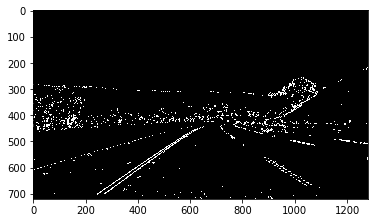

In [21]:
# set color map to gray, default is RGB
plt.imshow(abs_sobel_thresh(image, thresh=(20,110)),  cmap='gray');

#### Gradient Magnitude
The function below will filter based on a min/max magnitude for the gradient. This function is looking at the combined xy gradient, but it could be altered to filter on the magnitude in a single direction, or some linear combination of the two. 

In [22]:
def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    x = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel)
    y = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the xy magnitude 
    mag = np.sqrt(x**2 + y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale = np.max(mag)/255
    eightbit = (mag/scale).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(eightbit)
    binary_output[(eightbit > thresh[0]) & (eightbit < thresh[1])] =1 
    return binary_output

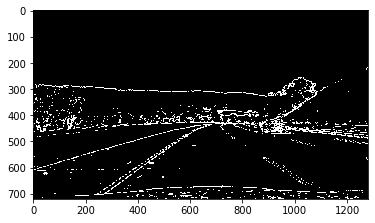

In [23]:
plt.imshow(mag_threshold(image, thresh=(20,100)),  cmap='gray');

#### Gradient Direction
This function will filter based on the direction of the gradient. For lane detection, we will be interested in vertical lines that are +/- some threshold near $\frac{\pi}{2}$

In [24]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    x = np.absolute(cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel))
    y = np.absolute(cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(y, x)
    binary_output = np.zeros_like(direction)
    binary_output[(direction > thresh[0]) & (direction < thresh[1])] = 1
    return binary_output

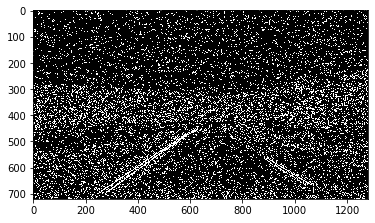

In [25]:
plt.imshow(dir_threshold(image, thresh=(0.8,1.2)),  cmap='gray');

#### Saturation Channel & Red Channel Filters
The gradient filters above all convert the original image into grayscale and a lot of useful information is lost. Lane lines are either yellow or white, and we can use that to our advantage trying to locate and track them. The **H**ue **S**aturation **L**ightness color space will help. In particular, the S channel of an HSL image retains a lot information about lane lines - especially when there are shadows on the road. The Red channel of RGB also does a good job of creating binary images of lane lines. 

In [26]:
def hls_select(img, sthresh=(0, 255),lthresh=()):
    # 1) Convert to HLS color space
    hls_img = cv.cvtColor(img, cv.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    L = hls_img[:,:,1]
    S = hls_img[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(S)
    binary_output[(S >= sthresh[0]) & (S <= sthresh[1])
                 & (L > lthresh[0]) & (L <= lthresh[1])] = 1
    return binary_output

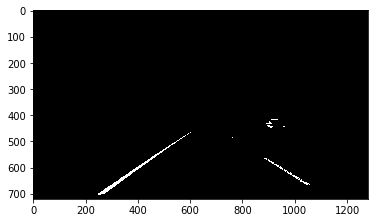

In [27]:
plt.imshow(hls_select(image, sthresh=(140,255), lthresh=(120, 255)),  cmap='gray');

In [28]:
def red_select(img, thresh=(0, 255)):
    # Apply a threshold to the R channel
    R = img[:,:,0]
    # Return a binary image of threshold result
    binary_output = np.zeros_like(R)
    binary_output[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary_output

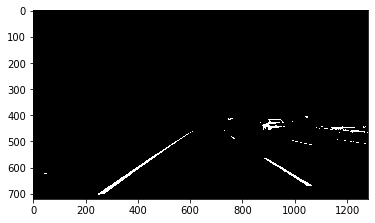

In [29]:
plt.imshow(red_select(image, thresh=(200,255)),  cmap='gray');

### Combining Filter Methods
We can now mix and match different filter methods, each with unique threshold values, to get a refined binary image.

In [30]:
def binary_pipeline(img):
    
    img_copy = cv.GaussianBlur(img, (3, 3), 0)
    #img_copy = np.copy(img)
    
    # color channels
    s_binary = hls_select(img_copy, sthresh=(140, 255), lthresh=(120, 255))
    #red_binary = red_select(img_copy, thresh=(200,255))
    
    # Sobel x
    x_binary = abs_sobel_thresh(img_copy,thresh=(25, 200))
    y_binary = abs_sobel_thresh(img_copy,thresh=(25, 200), orient='y')
    xy = cv.bitwise_and(x_binary, y_binary)
    
    #magnitude & direction
    mag_binary = mag_threshold(img_copy, sobel_kernel=3, thresh=(30,100))
    dir_binary = dir_threshold(img_copy, sobel_kernel=3, thresh=(0.8, 1.2))
    
    # Stack each channel
    gradient = np.zeros_like(s_binary)
    gradient[((x_binary == 1) & (y_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    final_binary = cv.bitwise_or(s_binary, gradient)
    
    return final_binary

I tested numerous bitwise combinations of many different filters. They all produced different results regarding the image as a whole, but this combination did the best job of retaining the information of the yellow lane line - especially as it gets further away and under shadows.

I have left in all of the other filters because they may prove useful in different lighting conditions. More test images are needed - especially night time images! 

### Combined Filter

<Figure size 432x288 with 0 Axes>

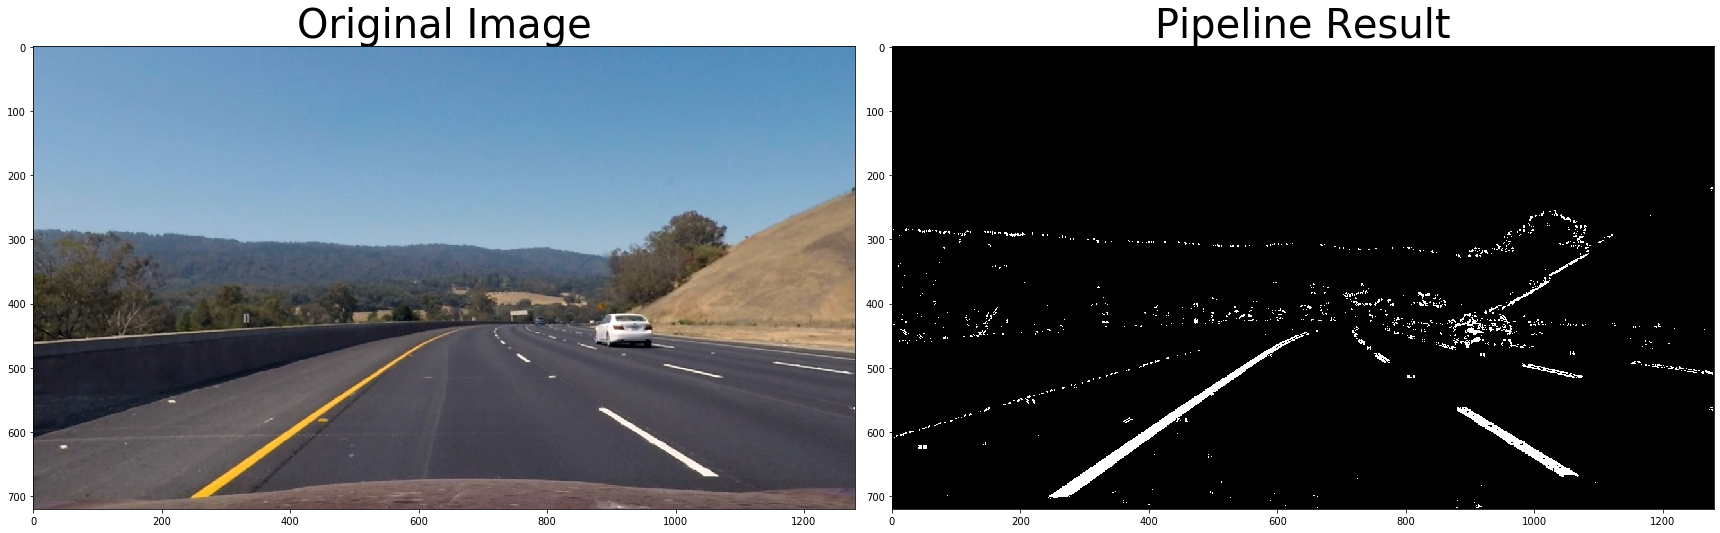

In [31]:
result = binary_pipeline(image)

# Plot the result
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.tight_layout()
plt.savefig('saved_figures/combined_filters.png')

Looks pretty good! It doesn't capture the yellow lane line in the distance as well as I would like. It clearly loses that information under shadow cast by the tree.

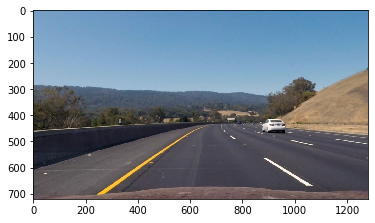

In [32]:
# get an undistorted dashcam frame
image = mpimg.imread('test_images/test3.jpg')
dim = (1280, 720)
# resize image
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
image = distort_correct(image,mtx,dist,camera_img_size)
plt.imshow(image);

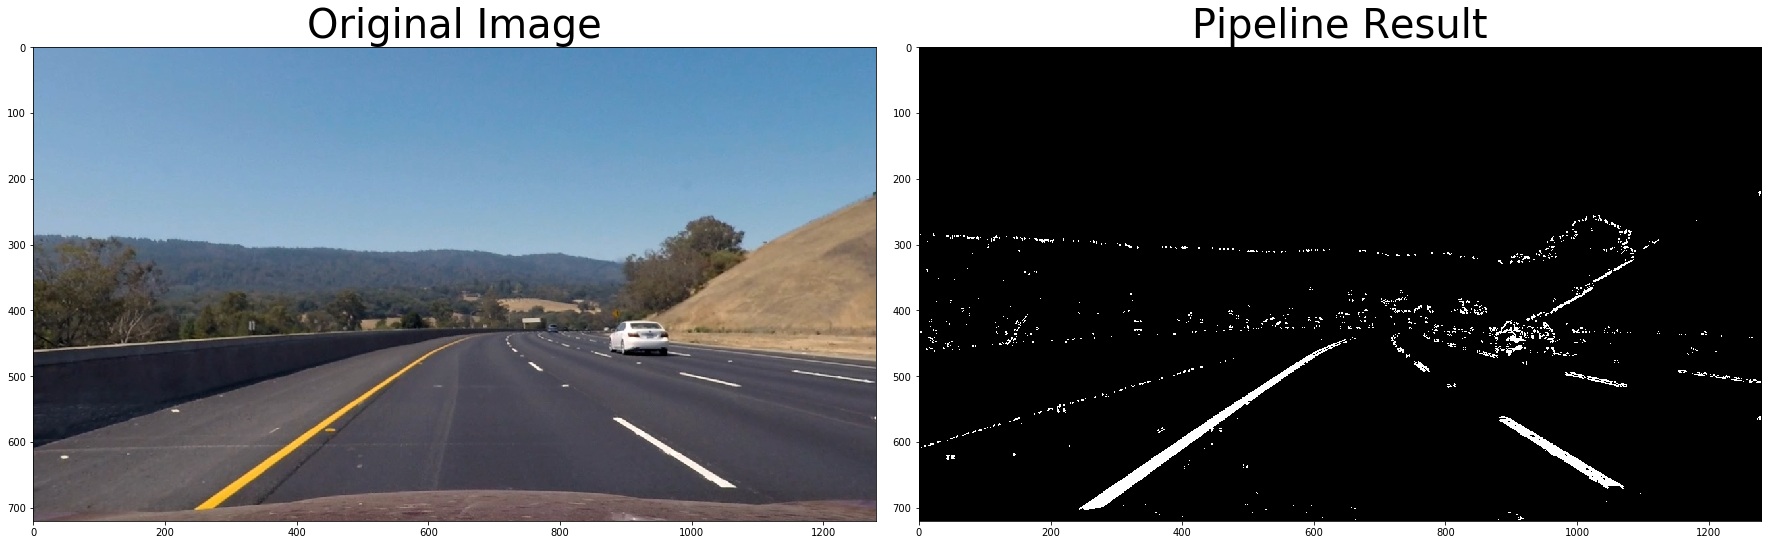

In [33]:
result = binary_pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

We can see here the pipeline does a much better job of resolving lines underneath shadows when they are closer/bigger to the camera. However, it is still not perfect.

---

### Perspective transform

In [34]:
def warp_image(img):
    
    image_size = (img.shape[1], img.shape[0])
    x = img.shape[1]
    y = img.shape[0]

    #the "order" of points in the polygon you are defining does not matter
    #but they need to match the corresponding points in destination_points!
    source_points = np.float32([
    [0.117 * x, y],
    [(0.5 * x) - (x*0.078), (2/3)*y],
    [(0.5 * x) + (x*0.078), (2/3)*y],
    [x - (0.117 * x), y]
    ])

#     #chicago footage
#     source_points = np.float32([
#                 [300, 720],
#                 [500, 600],
#                 [700, 600],
#                 [850, 720]
#                 ])
    
#     destination_points = np.float32([
#                 [200, 720],
#                 [200, 200],
#                 [1000, 200],
#                 [1000, 720]
#                 ])
    
    destination_points = np.float32([
    [0.25 * x, y],
    [0.25 * x, 0],
    [x - (0.25 * x), 0],
    [x - (0.25 * x), y]
    ])
    
    perspective_transform = cv.getPerspectiveTransform(source_points, destination_points)
    inverse_perspective_transform = cv.getPerspectiveTransform( destination_points, source_points)
    
    warped_img = cv.warpPerspective(img, perspective_transform, image_size, flags=cv.INTER_LINEAR)
    
    #print(source_points)
    #print(destination_points)
    
    return warped_img, inverse_perspective_transform

<Figure size 432x288 with 0 Axes>

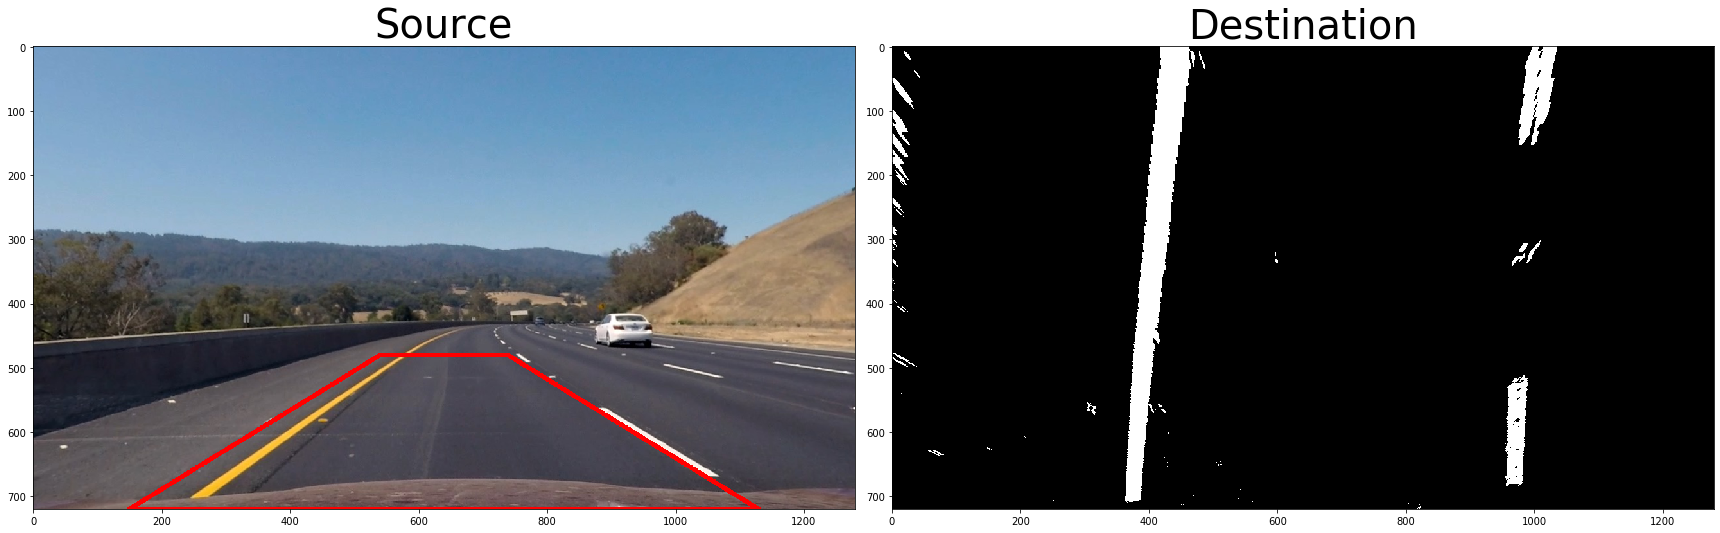

In [35]:
birdseye_result, inverse_perspective_transform = warp_image(result)

# Plot the result
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()


image_size = (image.shape[1], image.shape[0])
x = image.shape[1]
y = image.shape[0]
source_points = np.int32([
                    [0.117 * x, y],
                    [(0.5 * x) - (x*0.078), (2/3)*y],
                    [(0.5 * x) + (x*0.078), (2/3)*y],
                    [x - (0.117 * x), y]
                    ])

draw_poly = cv.polylines(image,[source_points],True,(255,0,0), 5)

ax1.imshow(draw_poly)
ax1.set_title('Source', fontsize=40)
ax2.imshow(birdseye_result, cmap='gray')
ax2.set_title('Destination', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.tight_layout()
plt.savefig('saved_figures/perspective_transform.png')

In [61]:
# reload the image for later use
image = mpimg.imread('/home/abhishek/Desktop/dip project/car detection1.png')
dim = (1280, 720)
# resize image
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
image = distort_correct(image,mtx,dist,camera_img_size)

---

### Detecting Lane Lines

Now that our snapshot of the road has been transformed, we are ready to find and track the actual lane lanes. To do this, we can identify areas with a high count of white pixels. Specifically, we will use a histogram to bin the pixels into columns and look for peaks in the distribution.

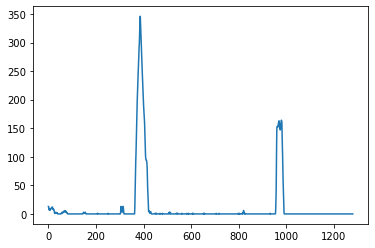

In [62]:
#look at only lower half of image
histogram = np.sum(birdseye_result[int(birdseye_result.shape[0]/2):,:], axis=0)
plt.figure();
plt.plot(histogram);
plt.savefig('saved_figures/lane_histogram.png')

We can clearly see where the lanes are in this histogram. By implementing a sliding window, we can track the peaks as they veer left/right due to the slight curvature of the road.

The function below works as follows:
1. Create a search window on the bottom of the image whose height is $\frac{1}{9}$ of the image's height. 
2. Split the window into left and right halves.
3. Locate the pixel column with the highest value via histogram.
4. Draw a box around that area using a margin variable. 
5. Identify all of the non-zero pixels in that box. If there are enough, center the box on their mean position for the next window. 
6. Fit a quadradtic equation to all of the non-zero pixels identified in each half of the image (left lane and right lane)

In [63]:
def track_lanes_initialize(binary_warped):
    
    global window_search
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # we need max for each half of the histogram. the example above shows how
    # things could be complicated if didn't split the image in half 
    # before taking the top 2 maxes
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    # this will throw an error in the height if it doesn't evenly divide the img height
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = int(binary_warped.shape[0] - (window+1)*window_height)
        win_y_high = int(binary_warped.shape[0] - window*window_height)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit,right_fit

In [64]:
left_fit,right_fit = track_lanes_initialize(birdseye_result)

Here's what the result looks like:

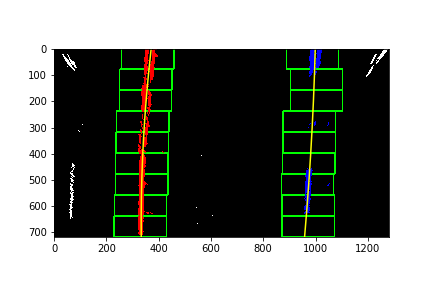

In [65]:
Image('saved_figures/01_window_search.png')

Now that we have found the lanes, we can refine the area we will search in to speed up the process. The function below works as follows:
    1. Import the polynomials.
    2. Look within a pixel margin for non-zero pixels.
    3. Fit a update the polynomials to fit new data. 

In [66]:
def track_lanes_update(binary_warped, left_fit,right_fit):

    global window_search
    global frame_count
    
    # repeat window search to maintain stability
    if frame_count % 10 == 0:
        window_search=True
   
        
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    return left_fit,right_fit,leftx,lefty,rightx,righty

In [67]:
global frame_count
frame_count=0
left_fit,right_fit,leftx,lefty,rightx,righty = track_lanes_update(birdseye_result, left_fit,right_fit)

Here's what the new search area looks like:

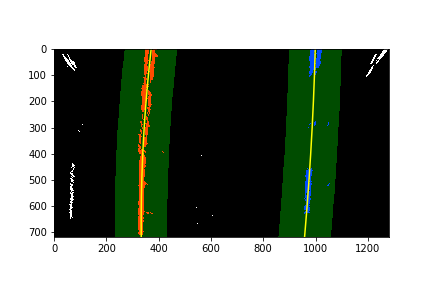

In [68]:
Image('saved_figures/02_updated_search_window.png')

---

### Drawing the lane on the original image

Now that we know where the lanes are, we can output that to the actual video feed. We'll do it in these steps:
    1. Import the polynomials
    2. Draw the polynomial curves on a blank copy of the warped binary
    3. Fill the polygon between the curves
    4. Unwarp the new image using the inverse perspective transformation
    5. Overlay the lane image on top of the original frame

In [69]:
# A function to get quadratic polynomial output
def get_val(y,poly_coeff):
    return poly_coeff[0]*y**2+poly_coeff[1]*y+poly_coeff[2]

In [70]:
def lane_fill_poly(binary_warped,undist,left_fit,right_fit):
    
    # Generate x and y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = get_val(ploty,left_fit)
    right_fitx = get_val(ploty,right_fit)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast x and y for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane 
    cv.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp using inverse perspective transform
    newwarp = cv.warpPerspective(color_warp, inverse_perspective_transform, (binary_warped.shape[1], binary_warped.shape[0])) 
    # overlay
    #newwarp = cv.cvtColor(newwarp, cv.COLOR_BGR2RGB)
    result = cv.addWeighted(undist, 1, newwarp, 0.3, 0)
        
    return result

In [71]:
colored_lane = lane_fill_poly(birdseye_result, image, left_fit, right_fit)
plt.figure()
plt.imshow(colored_lane);
plt.tight_layout()
plt.savefig('saved_figures/lane_polygon.png')

error: OpenCV(4.2.0) /io/opencv/modules/core/src/arithm.cpp:669: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


---

### Determine the lane curvature

Now that we have the lanes, we will want to compute the radius of the curvature (i.e. how much the road is curving). This information will be critical later in the end-to-end learning process when we need to create programs that will govern the steering and acceleration of the car. The most important step in this process will be converting our measurements from pixel space to the metric system. The formula for radius of curvature is given as:

$$R_{curve}=\frac{[1+(\frac{dx}{dy})^2]^\frac{3}{2}}{|\frac{d^2x}{dy^2}|}$$

Where the second order polynomial $f(y)$ is defined as:

$$f(y)=Ay^2+By+C$$

Notice that it is $f(y)$ *not* $f(x)$. This is because in the lane lane, there may be more than one $y$ value for any given $x$.The first and second derivatives of $f(y)$ are below:

$$f'(y)=\frac{dx}{dy}=2Ay+B$$

$$f''(y)=\frac{d^2x}{dy^2}=2A$$

Which yields the form that will be used in the function below:

$$R_{curve}=\frac{[1+(2Ay+B)^2]^\frac{3}{2}}{|2A|}$$

We will extract coefficients $A$ and $B$ from the polynomials before plugging them into the explicit formula.

In [47]:
def measure_curve(binary_warped,left_fit,right_fit):
        
    # generate y values 
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # measure radius at the maximum y value, or bottom of the image
    # this is closest to the car 
    y_eval = np.max(ploty)
    
    # coversion rates for pixels to metric
    # THIS RATE CAN CHANGE GIVEN THE RESOLUTION OF THE CAMERA!!!!!
    # BE SURE TO CHANGE THIS IF USING DIFFERENT SIZE IMAGES!!!
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
   
    # x positions lanes
    leftx = get_val(ploty,left_fit)
    rightx = get_val(ploty,right_fit)

    # fit polynomials in metric 
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # calculate radii in metric from radius of curvature formula
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # averaged radius of curvature of left and right in real world space
    # should represent approximately the center of the road
    curve_rad = round((left_curverad + right_curverad)/2)
    
    return curve_rad

In [48]:
measure_curve(birdseye_result,left_fit, right_fit)

3036.0

---

### Determining where the vehicle is in the lane

It will also be important to know where the vehicle is located relative to the lane. For this project, we are assuming that the camera is mounted in the center of the car.

In [49]:
def vehicle_offset(img,left_fit,right_fit):
    
    # THIS RATE CAN CHANGE GIVEN THE RESOLUTION OF THE CAMERA!!!!!
    # BE SURE TO CHANGE THIS IF USING DIFFERENT SIZE IMAGES!!!
    xm_per_pix = 3.7/700 
    image_center = img.shape[1]/2
    
    ## find where lines hit the bottom of the image, closest to the car
    left_low = get_val(img.shape[0],left_fit)
    right_low = get_val(img.shape[0],right_fit)
    
    # pixel coordinate for center of lane
    lane_center = (left_low+right_low)/2.0
    
    ## vehicle offset
    distance = image_center - lane_center
    
    ## convert to metric
    return (round(distance*xm_per_pix,5))

In [50]:
offset = vehicle_offset(colored_lane, left_fit, right_fit)
print(offset)

-0.16533


---

## Image Processing Pipeline

We have all the components of the pipeline built out. Now, we need to combine them into a single pipeline that will run on video footage. We will make a frame class to keep track of different properties. This will be useful later when we want to smooth out the video processing, much like in the first project. 

In [51]:
def img_pipeline(img):
    
    global window_search
    global left_fit_prev
    global right_fit_prev
    global frame_count
    global curve_radius
    global offset
        
    # load camera matrix and distortion matrix
    camera = pickle.load(open( "camera_matrix.pkl", "rb" ))
    mtx = camera['mtx']
    dist = camera['dist']
    camera_img_size = camera['imagesize']
    
    #correct lens distortion
    undist = distort_correct(img,mtx,dist,camera_img_size)
    # get binary image
    binary_img = binary_pipeline(undist)
    #perspective transform
    birdseye, inverse_perspective_transform = warp_image(binary_img)
    
    if window_search:
        #window_search = False
        #window search
        left_fit,right_fit = track_lanes_initialize(birdseye)
        #store values
        left_fit_prev = left_fit
        right_fit_prev = right_fit
        
    else:
        #load values
        left_fit = left_fit_prev
        right_fit = right_fit_prev
        #search in margin of polynomials
        left_fit,right_fit,leftx,lefty,rightx,righty = track_lanes_update(birdseye, left_fit,right_fit)
    
    #save values
    left_fit_prev = left_fit
    right_fit_prev = right_fit
    
    #draw polygon
    processed_frame = lane_fill_poly(birdseye, undist, left_fit, right_fit)
    
    #update ~twice per second
    if frame_count==0 or frame_count%15==0:
        #measure radii
        curve_radius = measure_curve(birdseye,left_fit,right_fit)
        #measure offset
        offset = vehicle_offset(undist, left_fit, right_fit)
    
        
    #printing information to frame
    font = cv.FONT_HERSHEY_TRIPLEX
    processed_frame = cv.putText(processed_frame, 'Radius: '+str(curve_radius)+' m', (30, 40), font, 1, (0,255,0), 2)
    processed_frame = cv.putText(processed_frame, 'Offset: '+str(offset)+' m', (30, 80), font, 1, (0,255,0), 2)
   
    frame_count += 1
    return processed_frame

## Let's test it out!
### Still Frames

In [56]:
filenames = os.listdir("test_images/")
global window_search
global frame_count
for filename in filenames:
    frame_count = 15
    window_search = True
    image = mpimg.imread('test_images/'+filename)
    lane_image = img_pipeline(image)
    mpimg.imsave('output_images/lane_'+filename,lane_image)

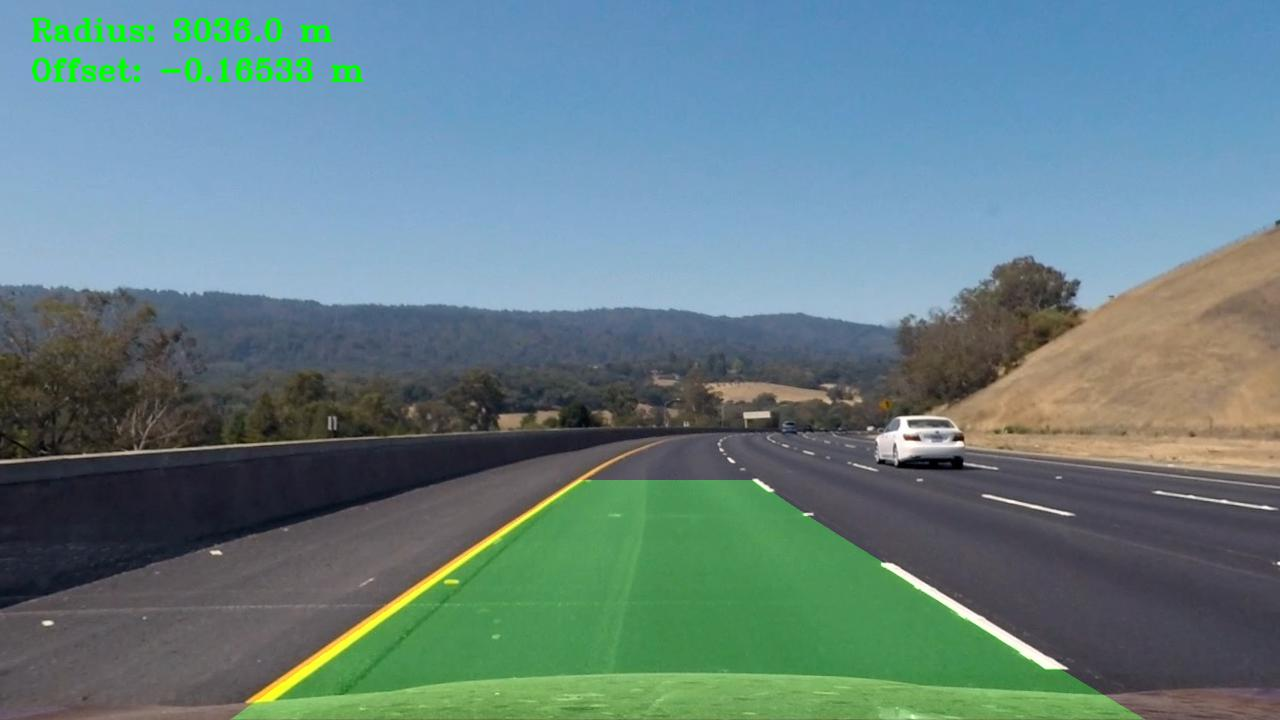

In [58]:
Image('output_images/lane_test3.jpg')

### Video Processing

In [50]:
from moviepy.video.fx.all import crop

In [52]:
global window_search 
global frame_count
window_search = True
frame_count = 0

#chicago footage
for filename in ['Lane Detection Test Video 01.mp4']:
    clip = VideoFileClip('videos/'+filename)#.subclip((3,25),(3,35))
    #clip_crop = crop(clip, x1=320, y1=0, x2=1600, y2=720)
    out= clip.fl_image(img_pipeline)
    #out = clip_crop.fl_image(img_pipeline)
    out.write_videofile('videos/processed_'+filename, audio=False, verbose=False)
    print('Success!')

t:   0%|          | 2/892 [00:00<01:12, 12.35it/s, now=None]

Moviepy - Building video videos/processed_Lane Detection Test Video 01.mp4.
Moviepy - Writing video videos/processed_Lane Detection Test Video 01.mp4



Moviepy - Done !
Moviepy - video ready videos/processed_Lane Detection Test Video 01.mp4
Success!


In [ ]:
video = 'videos/processed_project_video.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video))

In [1]:
from moviepy.editor import *

video = VideoFileClip("/home/abhishek/Desktop/dip project/SDC-Lane-and-Vehicle-Detection-Tracking-master/Part II - Adv Lane Detection and Road Features/videos/processed_project_video.mp4")

# Make the text. Many more options are available.
# txt_clip = ( TextClip("object detection",fontsize=70,color='white')
#              .set_position('top')
#              .set_duration(10) )

result = CompositeVideoClip([video]) # Overlay text on video
result.write_videofile("processed_project_video.avi",fps=25,codec='png') # Many options...

ModuleNotFoundError: No module named 'moviepy'

---